<a href="https://colab.research.google.com/github/kmswin1/Pytorch-Study/blob/master/VAE%2C_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Colab 에서 Pytorch 세팅

In [0]:
import os
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

tcmalloc: large alloc 1073750016 bytes == 0x5cd96000 @  0x7f60b9f641c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


구글 드라이브 연동

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive
!mkdir data
!cp -r ./drive/"colab data" ./data
!ls data

라이브러리 로드

In [0]:
import os
import sys
import timeit
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

#plt.rc('text', usetex = True)
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = "15"

print('python version : ', sys.version)
print('numpy version : ', np.version.version)
print('scipy version : ', sp.__version__)
print('matplotlib version :', mpl.__version__)
print('pytorch version : ', torch.__version__)
print('Cuda : ', torch.cuda.is_available())

python version :  3.6.3 (default, Oct  3 2017, 21:45:48) 
[GCC 7.2.0]
numpy version :  1.14.5
scipy version :  0.19.1
matplotlib version : 2.1.2
pytorch version :  0.4.0
Cuda :  True


Hyperparameter 지정

In [0]:
batchSize = 256
learningRate = 0.001
epochNum = 80
inputDim = 28 * 28
hiddenDim = 400
latentDim = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Cifar-10 / Cifar-100 데이터

In [0]:
dataTrain = torchvision.datasets.MNIST(root = './data',
                                         train = True,
                                         download = True,
                                         transform = transforms.ToTensor())

dataTest = torchvision.datasets.MNIST(root = './data',
                                         train = False,
                                         download = True,
                                         transform = transforms.ToTensor())

trainLoader = torch.utils.data.DataLoader(dataset = dataTrain, 
                                         batch_size = batchSize, 
                                         shuffle = True)

testLoader = torch.utils.data.DataLoader(dataset = dataTest, 
                                         batch_size = batchSize, 
                                         shuffle = False)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

Processing...
Done!


데이터 미리보기

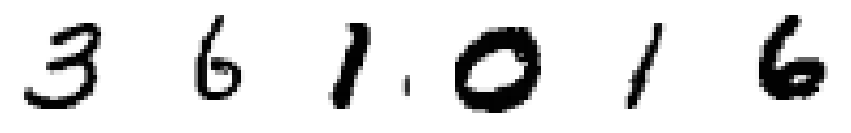

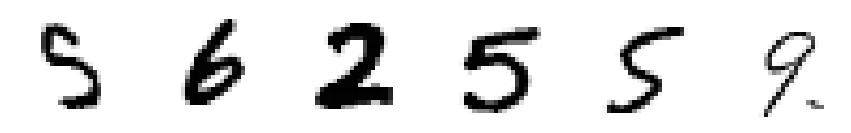

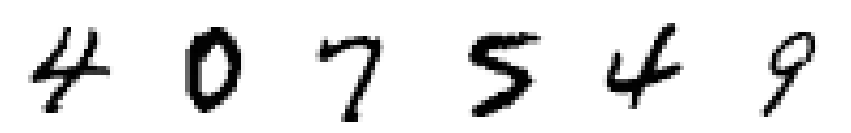

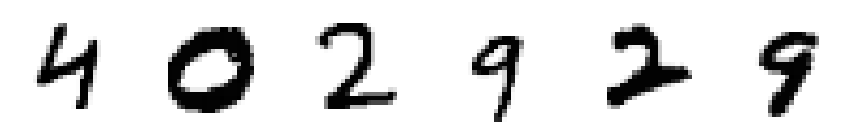

In [0]:
# 학습 데이터 출력을 위한 함수입니다.
def show_images(image, n_row):
  
  for _ in range(n_row):  
  
    index=np.random.choice(100, 6) # 0 ~ 99의 정수 중  6개 랜덤 샘플링
    images =image.numpy()[index] # 랜덤 샘플링 된 index에 해당하는 이미지 변수 저장
    
    plt.figure(figsize=(15,90)) # 세로 사이즈 15, 가로 사이즈 15*6
    
    for a in range(161, 167):    
    
      plt.subplot(a)
      plt.imshow(images[a-161])
      plt.xticks([])
      plt.yticks([])    
    
    plt.show()  

def test_and_show(D, fixed_z):
  
  D.eval()
  fake_images = D(fixed_z).view(-1, 28, 28) # 다시 이미지로 원상 복구시키기
  images_to_show = fake_images.data.cpu().squeeze().numpy() # numpy로 전환 (pyplot 연동을 위한)
  
  plt.figure(figsize=(10,60)) # 세로 사이즈: 10, 가로 사이즈: 10*6
  for a in range(161, 167):
    plt.subplot(a)
    plt.imshow(images_to_show[a-161])
    plt.xticks([]) # x tick 제거
    plt.yticks([]) # y tick 제거
  plt.show()

# 학습 데이터가 어떻게 생겼는지 출력해 볼 수 있습니다.
for i, (image,_) in enumerate(trainLoader): 
  
  show_images(image.squeeze(), 4)
  break

모델 구현

In [0]:
class Encoder(nn.Module):
  
  def __init__(self, inputDim, hiddenDim, outputDim):
    
    super(Encoder, self).__init__()
    
    self.hiddenDim = hiddenDim
    self.outputDim = outputDim
    self.fc1 = nn.Linear(inputDim, hiddenDim)
    self.latent = nn.Linear(hiddenDim, outputDim * 2) # mu and sigma
    self.relu = nn.ReLU(inplace = True)
    
  def forward(self, x):
    
    out = x
    out = self.fc1(out)
    out = self.relu(out)
    out = self.latent(out)
    
    return out
  
class Decoder(nn.Module):
  
  def __init__(self, latentDim, hiddenDim, outputDim):
    
    super(Decoder, self).__init__()
    
    self.hiddenDim = hiddenDim
    self.outputDim = outputDim
    self.fc1 = nn.Linear(latentDim, hiddenDim)
    self.fc2 = nn.Linear(hiddenDim, outputDim)
    self.relu = nn.ReLU(inplace = True)
    self.sigmoid = nn.Sigmoid()
    
  def forward(self, x):
    
    out = x
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.sigmoid(out)
    
    return out

encoder = Encoder(inputDim, hiddenDim, latentDim).to(device)
decoder = Decoder(latentDim, hiddenDim, inputDim).to(device)

학습

Epoch [1/80], Step [200/235] Loss: 39219.3359


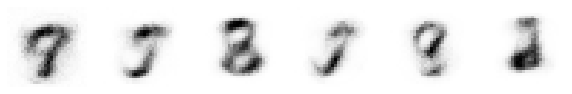

Epoch [2/80], Step [200/235] Loss: 34268.8789


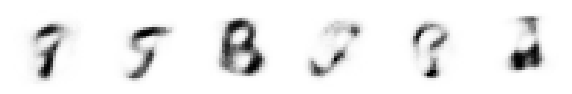

Epoch [3/80], Step [200/235] Loss: 31714.2188


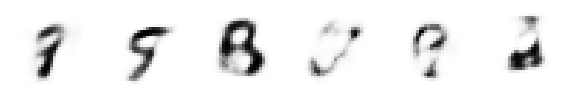

Epoch [4/80], Step [200/235] Loss: 30112.9141


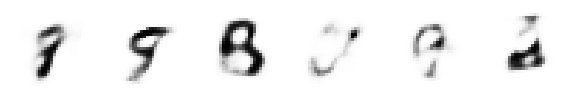

Epoch [5/80], Step [200/235] Loss: 29088.9453


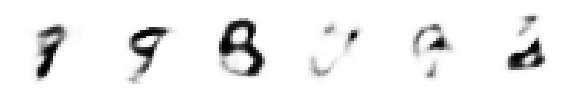

Epoch [6/80], Step [200/235] Loss: 29132.3359


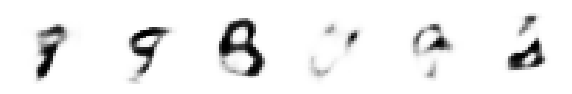

Epoch [7/80], Step [200/235] Loss: 27244.2031


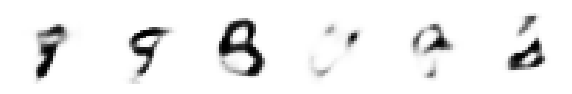

Epoch [8/80], Step [200/235] Loss: 28162.0547


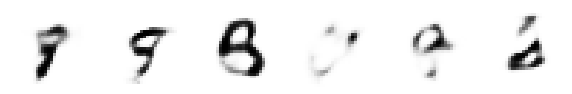

Epoch [9/80], Step [200/235] Loss: 28429.1641


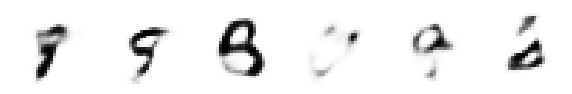

Epoch [10/80], Step [200/235] Loss: 26905.1133


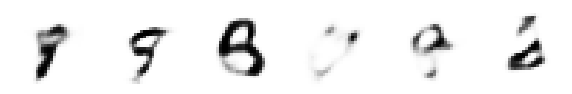

Epoch [11/80], Step [200/235] Loss: 27354.1289


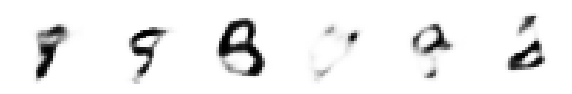

Epoch [12/80], Step [200/235] Loss: 26952.4180


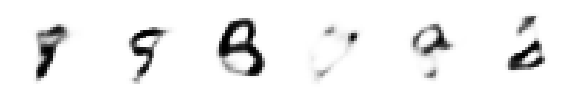

Epoch [13/80], Step [200/235] Loss: 26698.5996


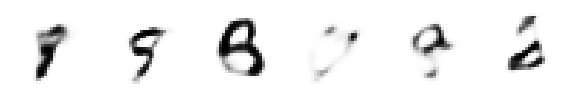

Epoch [14/80], Step [200/235] Loss: 26503.1543


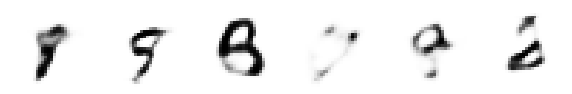

Epoch [15/80], Step [200/235] Loss: 27080.4277


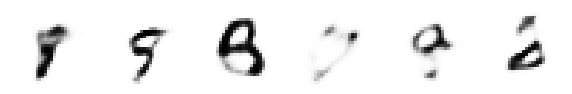

Epoch [16/80], Step [200/235] Loss: 27001.2969


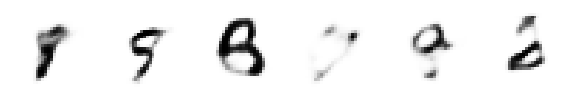

Epoch [17/80], Step [200/235] Loss: 26644.8906


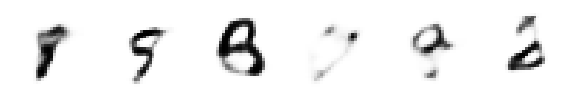

Epoch [18/80], Step [200/235] Loss: 27400.2070


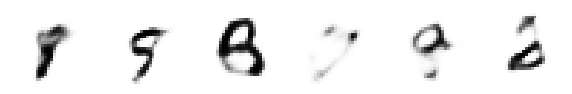

Epoch [19/80], Step [200/235] Loss: 26475.2773


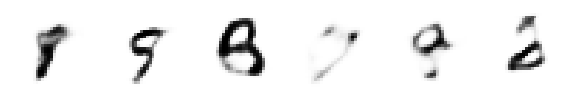

Epoch [20/80], Step [200/235] Loss: 26198.7344


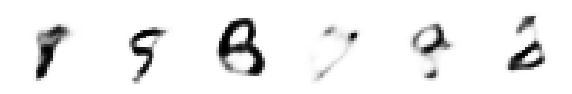

Epoch [21/80], Step [200/235] Loss: 27173.7617


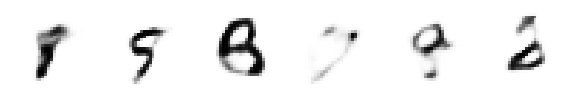

Epoch [22/80], Step [200/235] Loss: 26841.0742


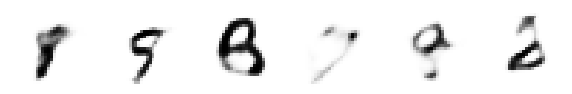

Epoch [23/80], Step [200/235] Loss: 25878.7363


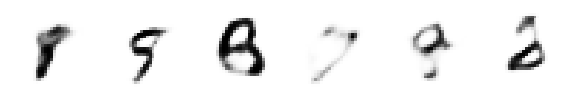

Epoch [24/80], Step [200/235] Loss: 26571.8984


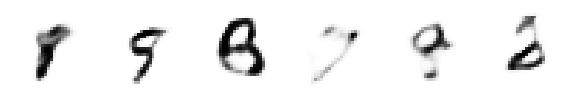

Epoch [25/80], Step [200/235] Loss: 27044.6719


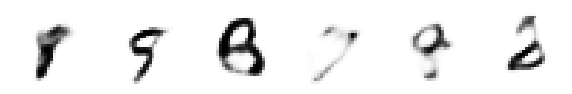

Epoch [26/80], Step [200/235] Loss: 27272.4570


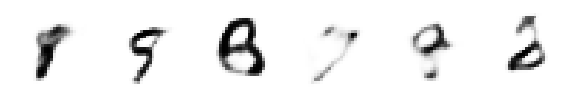

Epoch [27/80], Step [200/235] Loss: 26654.9961


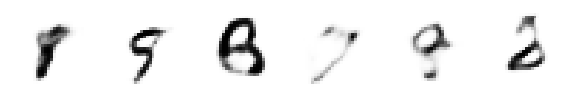

Epoch [28/80], Step [200/235] Loss: 26451.5312


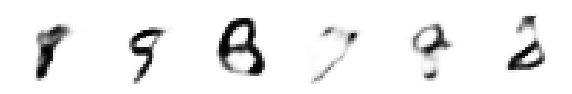

Epoch [29/80], Step [200/235] Loss: 26782.2695


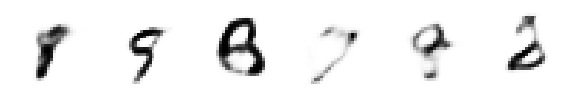

Epoch [30/80], Step [200/235] Loss: 27408.6758


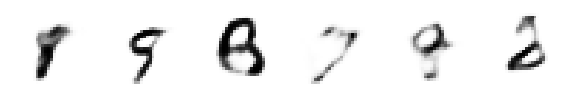

Epoch [31/80], Step [200/235] Loss: 26774.1445


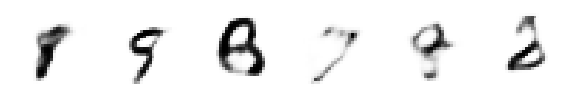

Epoch [32/80], Step [200/235] Loss: 26505.1777


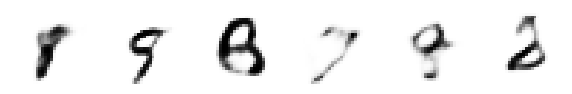

Epoch [33/80], Step [200/235] Loss: 26996.5781


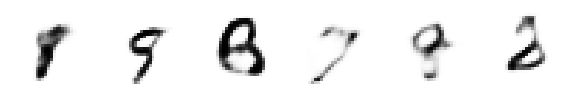

Epoch [34/80], Step [200/235] Loss: 26322.1133


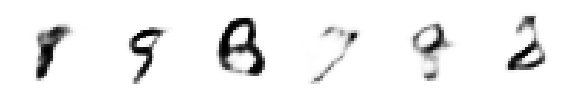

Epoch [35/80], Step [200/235] Loss: 26548.3457


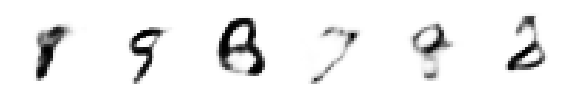

Epoch [36/80], Step [200/235] Loss: 26451.5703


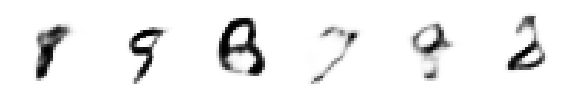

Epoch [37/80], Step [200/235] Loss: 26231.2305


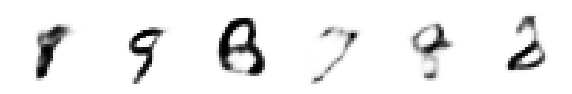

Epoch [38/80], Step [200/235] Loss: 26066.4648


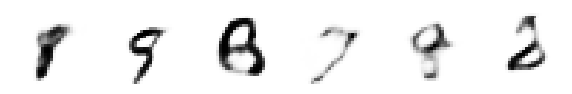

Epoch [39/80], Step [200/235] Loss: 25680.5645


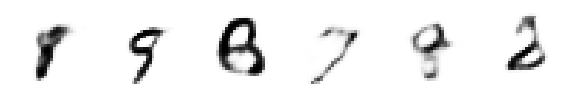

Epoch [40/80], Step [200/235] Loss: 25626.2188


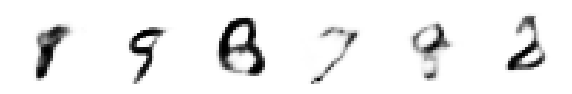

Epoch [41/80], Step [200/235] Loss: 26910.6074


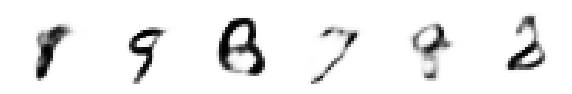

Epoch [42/80], Step [200/235] Loss: 26516.5215


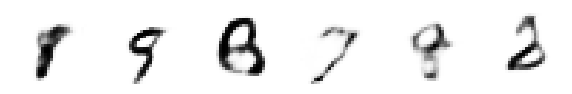

Epoch [43/80], Step [200/235] Loss: 26107.6035


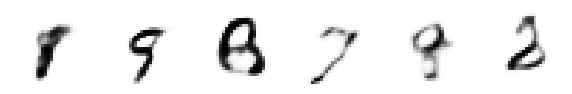

Epoch [44/80], Step [200/235] Loss: 26211.8438


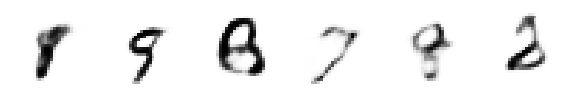

Epoch [45/80], Step [200/235] Loss: 26648.1387


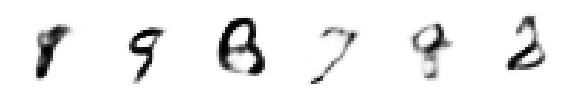

Epoch [46/80], Step [200/235] Loss: 26232.8047


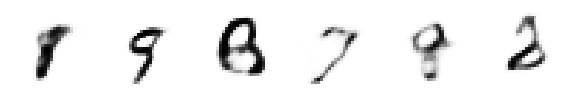

Epoch [47/80], Step [200/235] Loss: 26271.1934


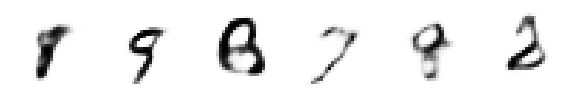

Epoch [48/80], Step [200/235] Loss: 25734.1289


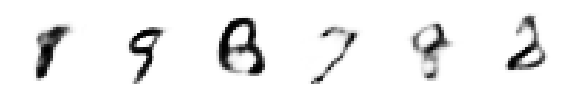

Epoch [49/80], Step [200/235] Loss: 25916.2266


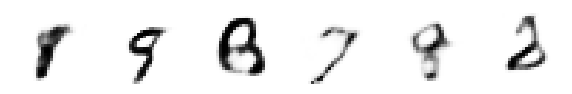

Epoch [50/80], Step [200/235] Loss: 25836.2344


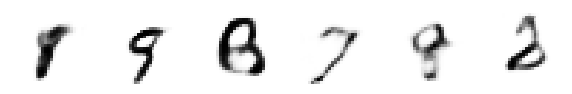

Epoch [51/80], Step [200/235] Loss: 26452.9062


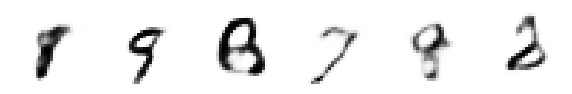

Epoch [52/80], Step [200/235] Loss: 26080.1328


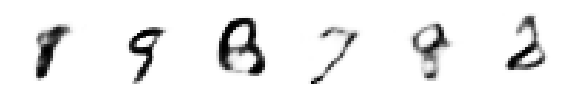

Epoch [53/80], Step [200/235] Loss: 26221.3398


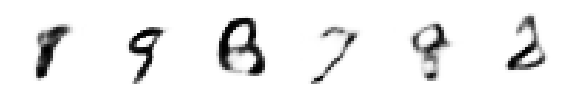

Epoch [54/80], Step [200/235] Loss: 26241.4336


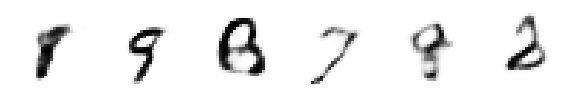

Epoch [55/80], Step [200/235] Loss: 26792.8809


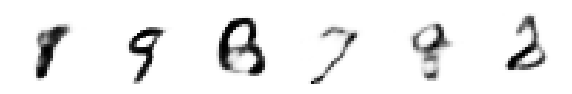

Epoch [56/80], Step [200/235] Loss: 26193.2598


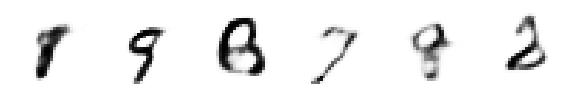

Epoch [57/80], Step [200/235] Loss: 26239.3945


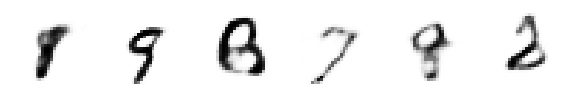

Epoch [58/80], Step [200/235] Loss: 24944.0625


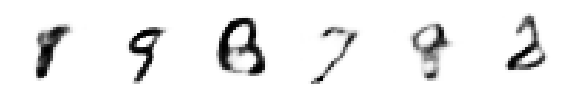

Epoch [59/80], Step [200/235] Loss: 25507.7578


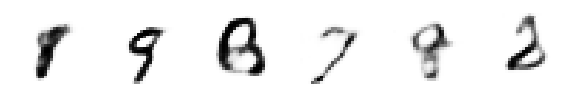

Epoch [60/80], Step [200/235] Loss: 26384.0918


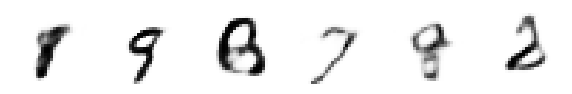

Epoch [61/80], Step [200/235] Loss: 26619.2246


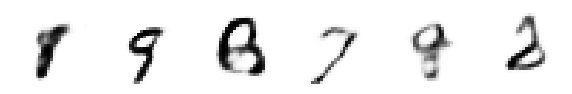

Epoch [62/80], Step [200/235] Loss: 25601.9844


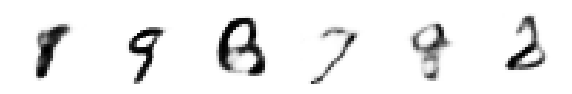

Epoch [63/80], Step [200/235] Loss: 25704.5078


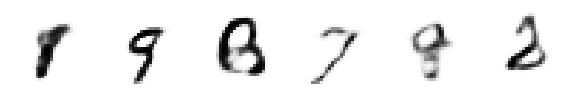

Epoch [64/80], Step [200/235] Loss: 25682.6797


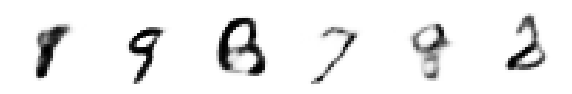

Epoch [65/80], Step [200/235] Loss: 25309.8809


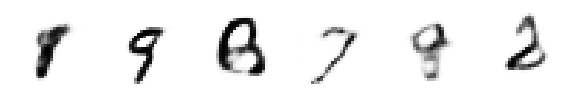

Epoch [66/80], Step [200/235] Loss: 26019.6367


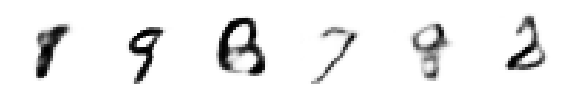

Epoch [67/80], Step [200/235] Loss: 25522.1465


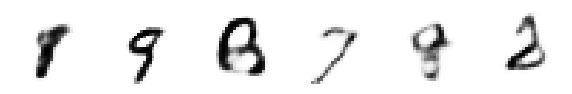

Epoch [68/80], Step [200/235] Loss: 25892.0156


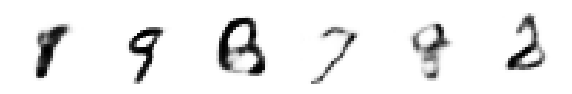

Epoch [69/80], Step [200/235] Loss: 25387.1035


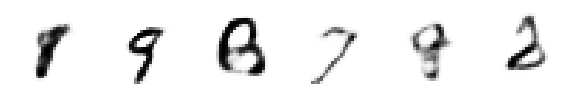

Epoch [70/80], Step [200/235] Loss: 25890.4395


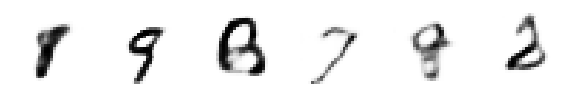

Epoch [71/80], Step [200/235] Loss: 26124.6289


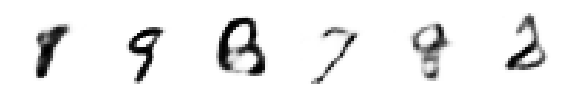

Epoch [72/80], Step [200/235] Loss: 25860.4883


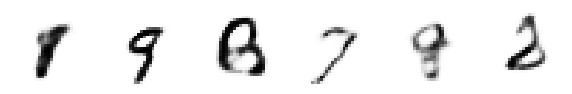

Epoch [73/80], Step [200/235] Loss: 25824.8340


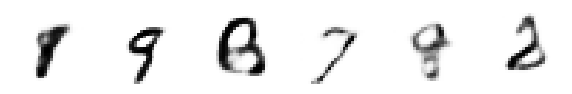

Epoch [74/80], Step [200/235] Loss: 26153.4863


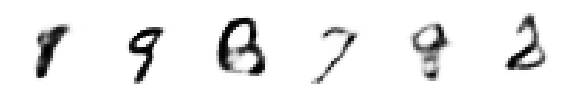

Epoch [75/80], Step [200/235] Loss: 26880.7852


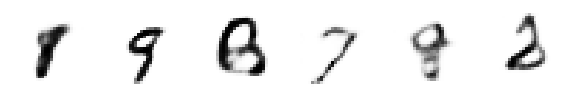

Epoch [76/80], Step [200/235] Loss: 26074.2773


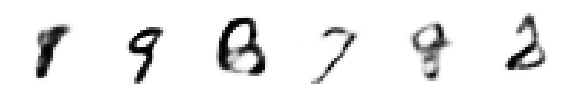

Epoch [77/80], Step [200/235] Loss: 25954.2129


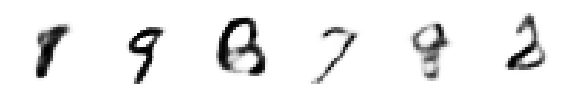

Epoch [78/80], Step [200/235] Loss: 25382.7793


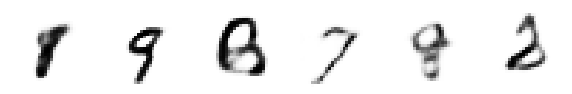

Epoch [79/80], Step [200/235] Loss: 25427.7734


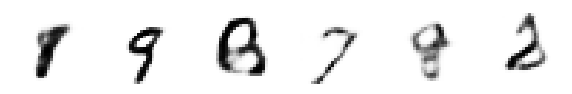

Epoch [80/80], Step [200/235] Loss: 25964.4688


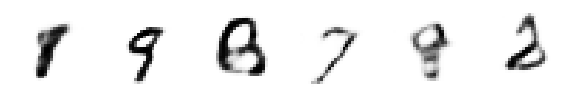

In [0]:
BCE = nn.BCELoss(size_average = False)

def criterion(reconstruct, x, mu, logvar):
  
  bce = BCE(reconstruct, x)
  kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  return bce + kld

def reparametize(mu, logvar):
  
  std = torch.exp(0.5 * logvar)
  eps = torch.randn_like(std)
  
  return eps.mul(std).add_(mu)

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr = learningRate)
totalStep = len(trainLoader)

fixedLatent = torch.randn(batchSize, latentDim).to(device)

for epoch in range(epochNum):
  
  try:
    
    for idx, (images, labels) in enumerate(trainLoader):
      
        encoder.train()
        decoder.train()
      
        real = images.view(batchSize, -1).to(device)
        latent = encoder(real)
        mu, logvar = torch.split(latent, latentDim, dim = 1)
        
        z = reparametize(mu, logvar)
        fake = decoder(z)
        loss = criterion(fake, real, mu, logvar)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (idx + 1) % 200 == 0:
            
            print("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}".format(epoch + 1, epochNum, idx + 1, totalStep, loss.item()))
            test_and_show(decoder, fixedLatent)
            
  except:
    
    continue

테스트

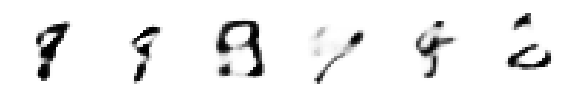

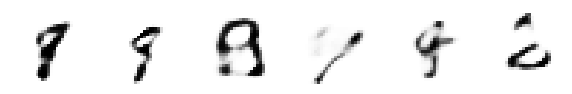

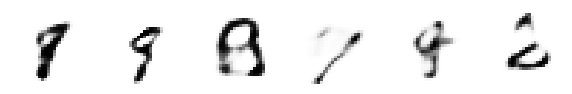

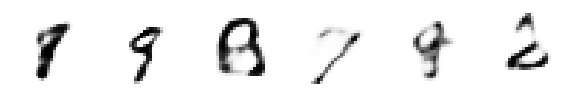

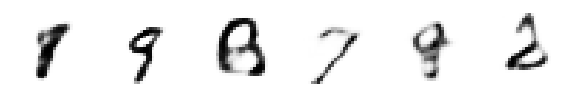

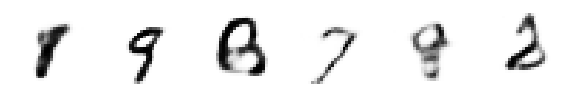

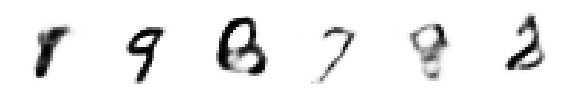

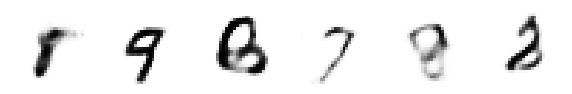

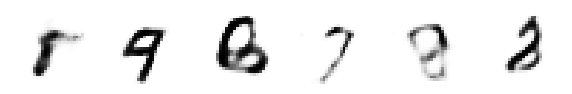

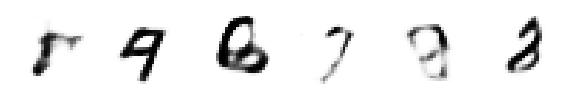

In [0]:
moveLatent = torch.randn(batchSize, latentDim).to(device)

for i in range(10):
  
  test_and_show(decoder, fixedLatent + 0.2 * (i - 5) * moveLatent)
  